In [1]:
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
from sklearn.neighbors import KDTree
import folium
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# --------------------------------
# Download the street network around the Quebec City/Lévis area with a large 10 km buffer
# --------------------------------

#https://github.com/gboeing/osmnx-examples/blob/master/notebooks/05-example-save-load-networks-shapes.ipynb

# from some place name, create a GeoDataFrame containing the geometry of the place
# define a list of place names
place = ['wendake,canada', 
               'Lévis, canada',
               'Québec city, canada',
               "L'ancienne-lorette, canada"
               ]


G = ox.graph_from_place(place, network_type='drive',
                       simplify=False,
                       retain_all=True,
                       buffer_dist = 10000    # pour pas avoir des gens pas mappables?
 )

ox.save_graph_shapefile(G, filename='original-network-shape')

In [3]:
# --------------------------------
#  create G_nobridge:  copy, add   speed limits, travel time,  simplify
# --------------------------------


#https://github.com/gboeing/osmnx-examples/blob/master/notebooks/04-example-simplify-network.ipynb
# simplify the network
G_nobridge = G.copy()


G_nobridge = ox.simplify_graph(G_nobridge)
# add speed limit and travel time after simplifying
#thisworks 
for u, v, k, data in G_nobridge.edges(data=True, keys=True):

  if 'highway' in data and data["highway"] == "motorway":
    data["speed_limit_kmh"] = 100
  elif 'highway':
    data["speed_limit_kmh"] = 50
    
    
for u, v, k, data in G_nobridge.edges(data=True, keys=True): # u et v sont les nodes origines destination
    data['time_minute'] = data['length'] / 1000 * 60 / data['speed_limit_kmh'] 
    

#https://medium.com/@bobhaffner/osmnx-intro-and-routing-1fd744ba23d8
ox.save_graph_shapefile(G_nobridge, filename='G_nobridge')

In [4]:
# --------------------------------
#  create G_bridge:  copy, add bridge, add  speed limits, travel time,  simplify
# --------------------------------

#https://github.com/gboeing/osmnx-examples/blob/master/notebooks/04-example-simplify-network.ipynb
# simplify the network
G_bridge = G.copy()

# lien vers autoroute duplessis et de la capitale
G_bridge.add_node(999999999999999999999, x= -71.153, y= 46.866)

#longueur calculées dans qgis avec  http://www.qgistutorials.com/en/docs/calculating_line_lengths.html
# à investiguer: adD_edge_lengths..

#québec:
#arrivées
#180699309     nord
#130153234  ouest
#130152949 est

#départs
#180672314   nord
#180688633 ouest
#269683680 est 

G_bridge.add_edge(999999999999999999999, 180699309, key=0,  highway = "motorway", oneway = False, length = 841)
G_bridge.add_edge(999999999999999999999, 130153234, key=0,  highway = "motorway", oneway = False, length = 875)
G_bridge.add_edge(999999999999999999999, 130152949, key=0,  highway = "motorway", oneway = False, length = 1069)
G_bridge.add_edge(180672314,999999999999999999999,  key=0,  highway = "motorway", oneway = False, length = 778)
G_bridge.add_edge(180688633,999999999999999999999,  key=0,  highway = "motorway", oneway = False, length = 1060)
G_bridge.add_edge(269683680,999999999999999999999,  key=0,  highway = "motorway", oneway = False, length = 1196)
#lien vers auroute 20

G_bridge.add_node(88888888888888888888, x= -71.1024, y= 46.8173)


#lallemand
#arrivée
#5728701577 est
#486128981 ouest
#départ
#486135896 ouest
#281651410 est

G_bridge.add_edge(88888888888888888888, 5728701577, key=0,  highway = "motorway", oneway = False, length = 624)
G_bridge.add_edge(88888888888888888888, 486128981,  key=0,  highway = "motorway", oneway = False, length = 1077)
G_bridge.add_edge(486135896, 88888888888888888888 ,  key=0,  highway = "motorway", oneway = False, length = 1050)
G.add_edge(281651410, 88888888888888888888 ,  key=0,  highway = "motorway", oneway = False, length = 782)

# lien entre les deux liens
G_bridge.add_edge(88888888888888888888, 999999999999999999999, key=0, highway = "motorway", oneway = False, length = 6648)
G_bridge.add_edge(999999999999999999999, 88888888888888888888, key=0, highway = "motorway", oneway = False, length = 6648)

G_bridge = ox.simplify_graph(G_bridge)
# add speed limit and travel time after simplifying
#thisworks 
for u, v, k, data in G_bridge.edges(data=True, keys=True):

  if 'highway' in data and data["highway"] == "motorway":
    data["speed_limit_kmh"] = 100
  elif 'highway':
    data["speed_limit_kmh"] = 50
    
    
for u, v, k, data in G_bridge.edges(data=True, keys=True): # u et v sont les nodes origines destination
    data['time_minute'] = data['length'] / 1000 * 60 / data['speed_limit_kmh'] 
    

G_bridge = ox.project_graph(G_bridge)
ox.save_graph_shapefile(G_bridge, filename='G_bridge')

In [ ]:
# --------------------------------
#  create graph tree and list of nodes, allowing us to find nearest node of trips origins and destination
# --------------------------------
tree = KDTree(nodes_nobridge[['y', 'x']], metric='euclidean')

nodes_nobridge, edges_nobridge  = ox.graph_to_gdfs(G_nobridge)

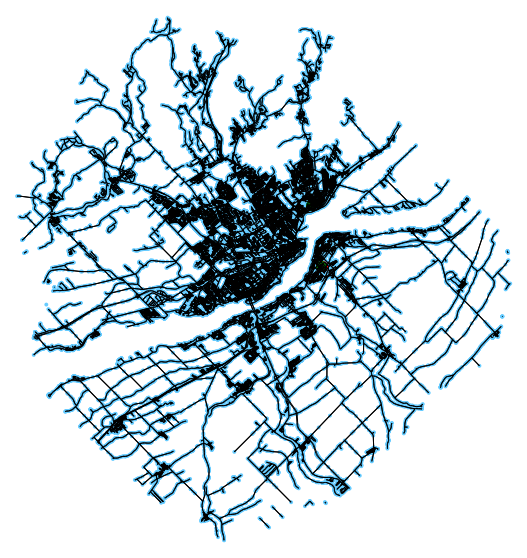

In [169]:
# --------------------------------
#  demo of finding nearest nodes
# --------------------------------

library = ox.geocode("lévis,canada")
museum = ox.geocode("beauport, Québec, Canada")

lib_idx = tree.query([library], k=1, return_distance=False)[0]
museum_idx = tree.query([museum], k=1, return_distance=False)[0]
closest_node_to_lib = nodes_nobridge.iloc[lib_idx].index.values[0]
closest_node_to_museum = nodes_nobridge.iloc[museum_idx].index.values[0]
fig, ax = ox.plot_graph(G, fig_height=10, fig_width=10, 
                        show=False, close=False, 
                        edge_color="black")
ax.scatter(library[1], library[0], c="red", s=100)
ax.scatter(museum[1], museum[0], c="blue", s=100)
ax.scatter(G.node[closest_node_to_lib]["x"],
           G.node[closest_node_to_lib]["y"], 
           c="green", s=100)
ax.scatter(G.node[closest_node_to_museum]["x"],   
           G.node[closest_node_to_museum]["y"], 
           c="green", s=100)
plt.show()

In [172]:
# --------------------------------
#  import trips, create origin and destination tuples, keep only trips that originate or end in the Quebec-Lévis region, add closest node to origin and destination
# --------------------------------

#readr::write_csv( trajets2 %>% st_set_geometry(NULL) %>% select(-origine, -destination) , "trajets2.csv")
trajets2 = pd.read_csv("trajets2.csv")

# https://stackoverflow.com/questions/16031056/how-to-form-tuple-column-from-two-columns-in-pandas

origine= list(zip(trajets2.origine_y.ravel(),trajets2.origine_x.ravel() ))
destination= list(zip(trajets2.destination_y.ravel(),trajets2.destination_x.ravel() ))
trajets2['origine'] = origine
trajets2['destination'] = destination

trajets2 =  trajets2[ (trajets2["ID_quartier_origine"] <  50) | (trajets2["ID_quartier_destination"] < 50)]

# http://book.pythontips.com/en/latest/map_filter.html
closest_node_to_origine = list(map(lambda x: nodes_nobridge.iloc[tree.query([x], k=1, return_distance=False)[0]].index.values[0],  
                                  trajets2["origine"]))
closest_node_to_destination = list(map(lambda x: nodes_nobridge.iloc[tree.query([x], k=1, return_distance=False)[0]].index.values[0], 
                                      trajets2["destination"]))

trajets2["closest_node_to_origine"] = closest_node_to_origine
trajets2["closest_node_to_destination"] = closest_node_to_destination

In [175]:
# --------------------------------
#  define tryconvert, which tries to return the shortest path between two nodes but will return a path of [0] if there is no path 
# --------------------------------

def tryconvert(closest_node_to_origine, closest_node_to_destination, G):
  try:
    goodpath = nx.shortest_path(G,
                   closest_node_to_origine,
                   closest_node_to_destination, weight = "time_minute")
    return(goodpath)
  except:
    return([0])

#tryconvert(307561537,2778622453, G_bridge) # returns 0
#tryconvert(2509788208,2496754005, G_bridge) #  returns full path



[2509788208,
 486197960,
 486134608,
 486145115,
 486145053,
 486189946,
 486207318,
 486158405,
 486157164,
 486199819,
 4659607785,
 2509801016,
 4584214894,
 486137790,
 486716147,
 486128986,
 486148096,
 486716157,
 291101916,
 486716210,
 281651356,
 286892203,
 286892129,
 286892166,
 291101977,
 243790303,
 243790308,
 2496754023,
 2496754020,
 2496754007,
 2496754008,
 3053391931,
 2496754005]

In [64]:
# --------------------------------
#  (longer, but not too long) evaluate the shortest paths with and without the bridge
# --------------------------------

routesss_nobridge =  list(map(tryconvert, 
                              closest_node_to_origine, # closest_node_to_origine[1:4]
                              closest_node_to_destination,
                             G_nobridge)) # closest_node_to_destination[1:4]

routesss_bridge =  list(map(tryconvert, 
                              closest_node_to_origine, # closest_node_to_origine[1:4]
                              closest_node_to_destination,
                           G_bridge)) # closest_node_to_destination[1:4]


In [176]:
# --------------------------------
#  what percentage of routes found no path?
# --------------------------------
no_route = list(map(lambda x: x == [0], routesss_nobridge))
mean_no_route = pd.Series( (v for v in no_route) ).mean()
mean_no_route

0.0022108172127911566

In [150]:
# --------------------------------
#  identify if the routes uses the Pont Pierre Laporte (North or South direction), the Pont de Québec (any direction) or the new link to the East 
# --------------------------------
pln_nobridge = list(map(lambda x: 1699454165 in x, routesss_nobridge))  # pont pierre laporte vers nord
pls_nobridge = list(map(lambda x: 1699454294 in x, routesss_nobridge)) # pont pierre laporte vers sud
pqc_nobridge = list(map(lambda x: 280618575 in x, routesss_nobridge)) # pont de québec toutes directions
pest_nobridge = list(map(lambda x: 88888888888888888888 in x, routesss_nobridge)) # 3eme lien a l'est

pln_bridge = list(map(lambda x: 1699454165 in x, routesss_bridge))
pls_bridge = list(map(lambda x: 1699454294 in x, routesss_bridge))
pqc_bridge = list(map(lambda x: 280618575 in x, routesss_bridge))
pest_bridge = list(map(lambda x: 88888888888888888888 in x, routesss_bridge))




In [177]:
# --------------------------------
#  print percentage that use each bridges - no third bridge
# --------------------------------
mean_pln_nobridge = pd.Series( (v for v in pln_nobridge) ).mean()
mean_pls_nobridge = pd.Series( (v for v in pls_nobridge) ).mean()
mean_pqc_nobridge = pd.Series( (v for v in pqc_nobridge) ).mean()
mean_pest_nobridge = pd.Series( (v for v in pest_nobridge) ).mean()

mean_pln_bridge = pd.Series( (v for v in pln_bridge) ).mean()
mean_pls_bridge = pd.Series( (v for v in pls_bridge) ).mean()
mean_pqc_bridge = pd.Series( (v for v in pqc_bridge) ).mean()
mean_pest_bridge = pd.Series( (v for v in pest_bridge) ).mean()


print(mean_pln_nobridge, mean_pls_nobridge, mean_pqc_nobridge, mean_pest_nobridge)
     

0.0987761547572049 0.090248716936439 0.0378997236478484 0.0


In [178]:
# --------------------------------
#  print percentage that use each bridges - with third bridge
# --------------------------------

print(mean_pln_bridge, mean_pls_bridge, mean_pqc_bridge, mean_pest_bridge)

0.08590604026845637 0.07958941966048164 0.037820765890248714 0.023608369522305567


In [180]:
# --------------------------------
#  make sure that the same amount of people cross the river with or without the new bridge
# --------------------------------
pct_nobridge = mean_pln_nobridge+ mean_pls_nobridge +mean_pqc_nobridge+ mean_pest_nobridge
pct_bridge = mean_pln_bridge+ mean_pls_bridge +mean_pqc_bridge+ mean_pest_bridge
print(pct_nobridge, pct_bridge)

0.2269245953414923 0.22692459534149229


In [148]:
# --------------------------------
#  function to extract edges from path so I can map the edges by the number of trips that used them
#  inspiration : https://github.com/gboeing/osmnx/blob/master/osmnx/plot.py   , function https://github.com/gboeing/osmnx/blob/master/osmnx/plot.py
# --------------------------------

def path_to_edge(path, G):
    edge_nodes = list(zip(path[:-1], path[1:]))
    return(edge_nodes)
  




In [184]:
# --------------------------------
#  count the occurrence of each edge
#  inspiration : https://stackoverflow.com/questions/2600191/how-can-i-count-the-occurrences-of-a-list-item
# --------------------------------

from collections import Counter

test = [j for i in edge_paths for j in i]
test


count_occurrences = Counter(test)

#count_occurrences[17052312,30898987] # 90

90

In [314]:
# --------------------------------
#  add occurrences count to edge data in graph
# --------------------------------


for u, v, k, data in G_nobridge.edges(data=True, keys=True):
  data["occurrences"] = count_occurrences[u,v]


for u, v, k, data in G_bridge.edges(data=True, keys=True):
  data["occurrences"] = count_occurrences[u,v]



In [197]:
# ok, the data occurences really has been created
for u, v, k, data in G_nobridge.edges(data=True, keys=True):
    if (u == 280618575) or (v == 280618575): # node pont de québec
        print(u, v, data["occurrences"] )

280618575 281357362 162
280618575 5301585427 229
280618575 281357344 65
281357362 280618575 240
5301585427 280618575 225


In [160]:
# or.. has it?

#nodes_nobridge,edges_nobridge = ox.graph_to_gdfs(G_nobridge)
#nodes_nobridge.head()
##edges_nobridge["highway"]



,highway,osmid,ref,x,y,geometry
17052312,NaN,17052312,NaN,-71.280285,46.724609,POINT (-71.28028500000001 46.7246095)
17052332,motorway_junction,17052332,305,-71.339633,46.679550,POINT (-71.3396329 46.67955)
17052376,NaN,17052376,NaN,-71.514679,46.615225,POINT (-71.5146791 46.6152254)
30898987,NaN,30898987,NaN,-71.285188,46.722283,POINT (-71.2851879 46.7222831)
31410240,motorway_junction,31410240,130,-71.281497,46.732970,POINT (-71.2814968 46.7329696)


In [251]:
# --------------------------------
#  graph network, coloring using occurrences
# https://geoffboeing.com/2016/11/osmnx-python-street-networks/
# --------------------------------

#function get_edge_colors_by_attr fails because we have so many edges with no occurrences:
# it is defined here : https://github.com/gboeing/osmnx/blob/master/osmnx/plot.py
ec = ox.get_edge_colors_by_attr(G_nobridge, attr='occurrences')


ValueError: Bin edges must be unique: array([   0.,    0.,    0.,    0.,    4., 1068.]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [299]:
# ------------------------------------
#  modify the call to pd.qcut to get my own edge colors
# first I called qcut with duplicated = 'drop' , but this raised the  "bin edges must be unique" error
# a solution is here: https://stackoverflow.com/questions/38309144/qcut-pandas-valueerror-bin-edges-must-be-unique
# I dont like it very much because everything that is not zero is very dark
# ------------------------------------
num_bins =5
attr_values = pd.Series([data["occurrences"] for u, v, key, data in G_nobridge.edges(keys=True, data=True)])
cmap='viridis'
start = 1 # I inverted the scale because I like large values to be dark..
stop = 0

cats = pd.qcut(attr_values.rank(method='first'), num_bins, labels=False)
colors = ox.get_colors(num_bins, cmap, start, stop)
ec = [colors[int(cat)] if pd.notnull(cat) else na_color for cat in cats]

pandas.core.series.Series

In [337]:
# -----------------------------
#  I preferSolution 2: bin1 contains only 0s   from  # https://stackoverflow.com/questions/20158597/how-to-qcut-with-non-unique-bin-edges/40548606#40548606
#  because it groups all zeroes in a bin, the evenly distributes the remaining values.
# problem:  pd.tools.tile._bins_to_cuts  doesnt exist, so we will use pd.cut instead
# mx = np.ma.masked_equal(arr, 0, copy=True)
# bins = algos.quantile(arr[~mx.mask], np.linspace(0, 1, 11))
# bins = np.insert(bins, 0, 0)
# bins[1] = bins[1]-(bins[1]/2)
# result = pd.tools.tile._bins_to_cuts(arr, bins, include_lowest=True)
# -----------------------------

num_bins =5
cmap='viridis'
start = 1 # I inverted the scale because I like large values to be dark..
stop = 0


import pandas.core.algorithms as algos
attr_values = pd.Series([data["occurrences"] for u, v, key, data in G_nobridge.edges(keys=True, data=True)])
arr = pd.DataFrame.to_numpy(attr_values, dtype=float)
mx = np.ma.masked_equal(arr, 0, copy=True)
bins = algos.quantile(arr[~mx.mask], np.linspace(0, 1, num_bins))
bins = np.insert(bins, 0, 0)
bins[1] = bins[1]-(bins[1]/2)
cats = pd.cut(arr, bins, right=True, labels=False, retbins=False, precision=3, include_lowest=True)
colors = ox.get_colors(num_bins, cmap, start, stop)
ec_nobridge = [colors[int(cat)] if pd.notnull(cat) else na_color for cat in cats]
bins

array([0.000e+00, 5.000e-01, 2.000e+00, 4.000e+00, 1.500e+01, 1.068e+03])

In [338]:
attr_values = pd.Series([data["occurrences"] for u, v, key, data in G_bridge.edges(keys=True, data=True)])

arr = pd.DataFrame.to_numpy(attr_values, dtype=float)  # float is required, otherwise bin[1] - bin[1]/2 may lead to duplicate bins again..
mx = np.ma.masked_equal(arr, 0, copy=True)
bins = algos.quantile(arr[~mx.mask], np.linspace(0, 1, num_bins))  
bins = np.insert(bins, 0, 0)
bins[1] = bins[1]-(bins[1]/2)
cats = pd.cut(arr, bins, right=True, labels=False, retbins=False, precision=3, include_lowest=True)
colors = ox.get_colors(num_bins, cmap, start, stop)
ec_bridge = [colors[int(cat)] if pd.notnull(cat) else na_color for cat in cats]
bins

array([0.000e+00, 5.000e-01, 2.000e+00, 5.000e+00, 1.500e+01, 1.068e+03])

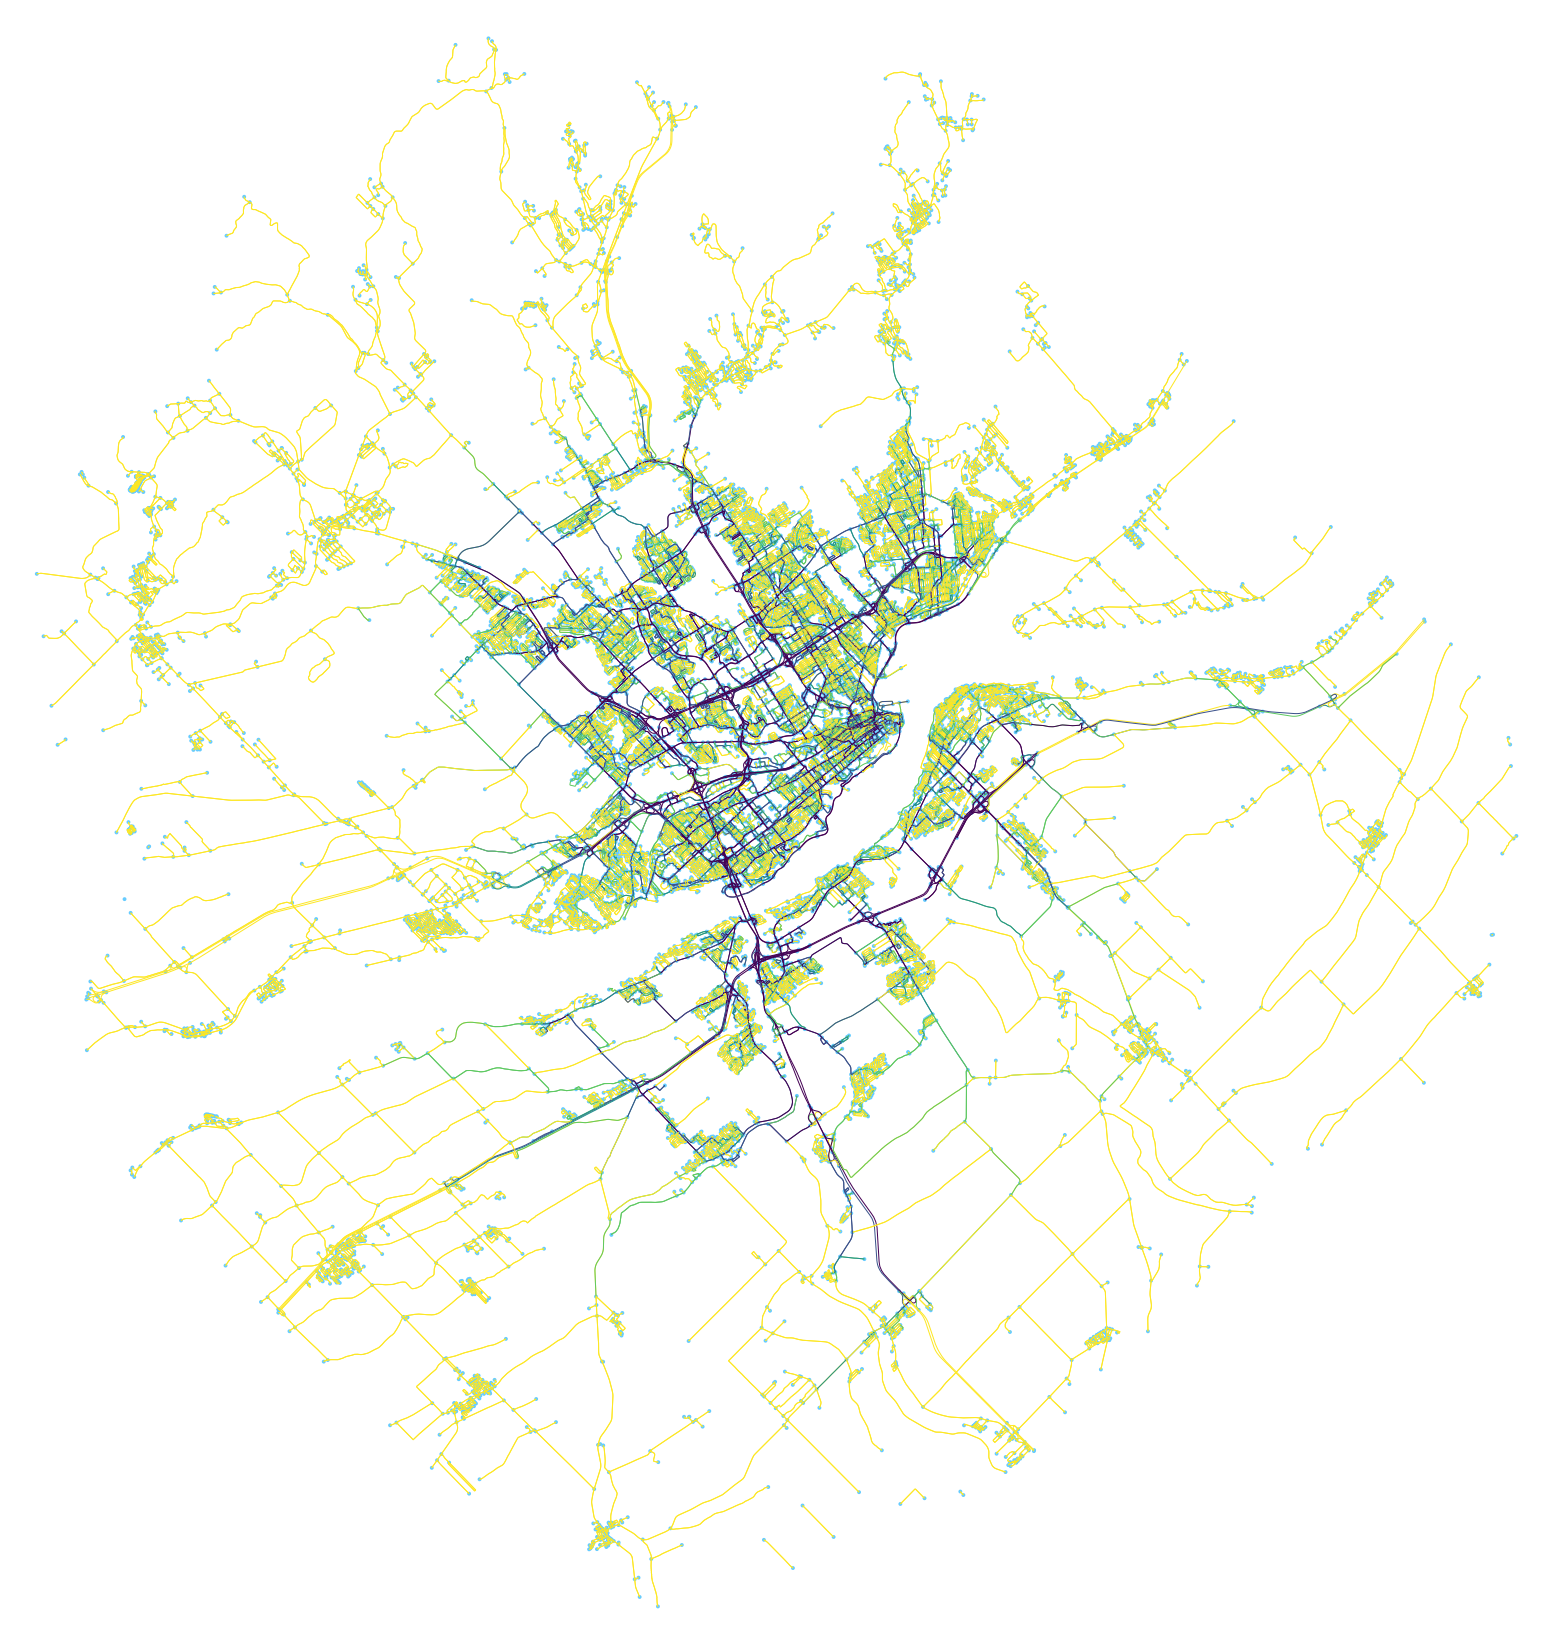

(<Figure size 2976.02x2160 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2af60a55c0>)

In [342]:
ox.plot_graph(G_nobridge, edge_color=ec,  fig_height=30)


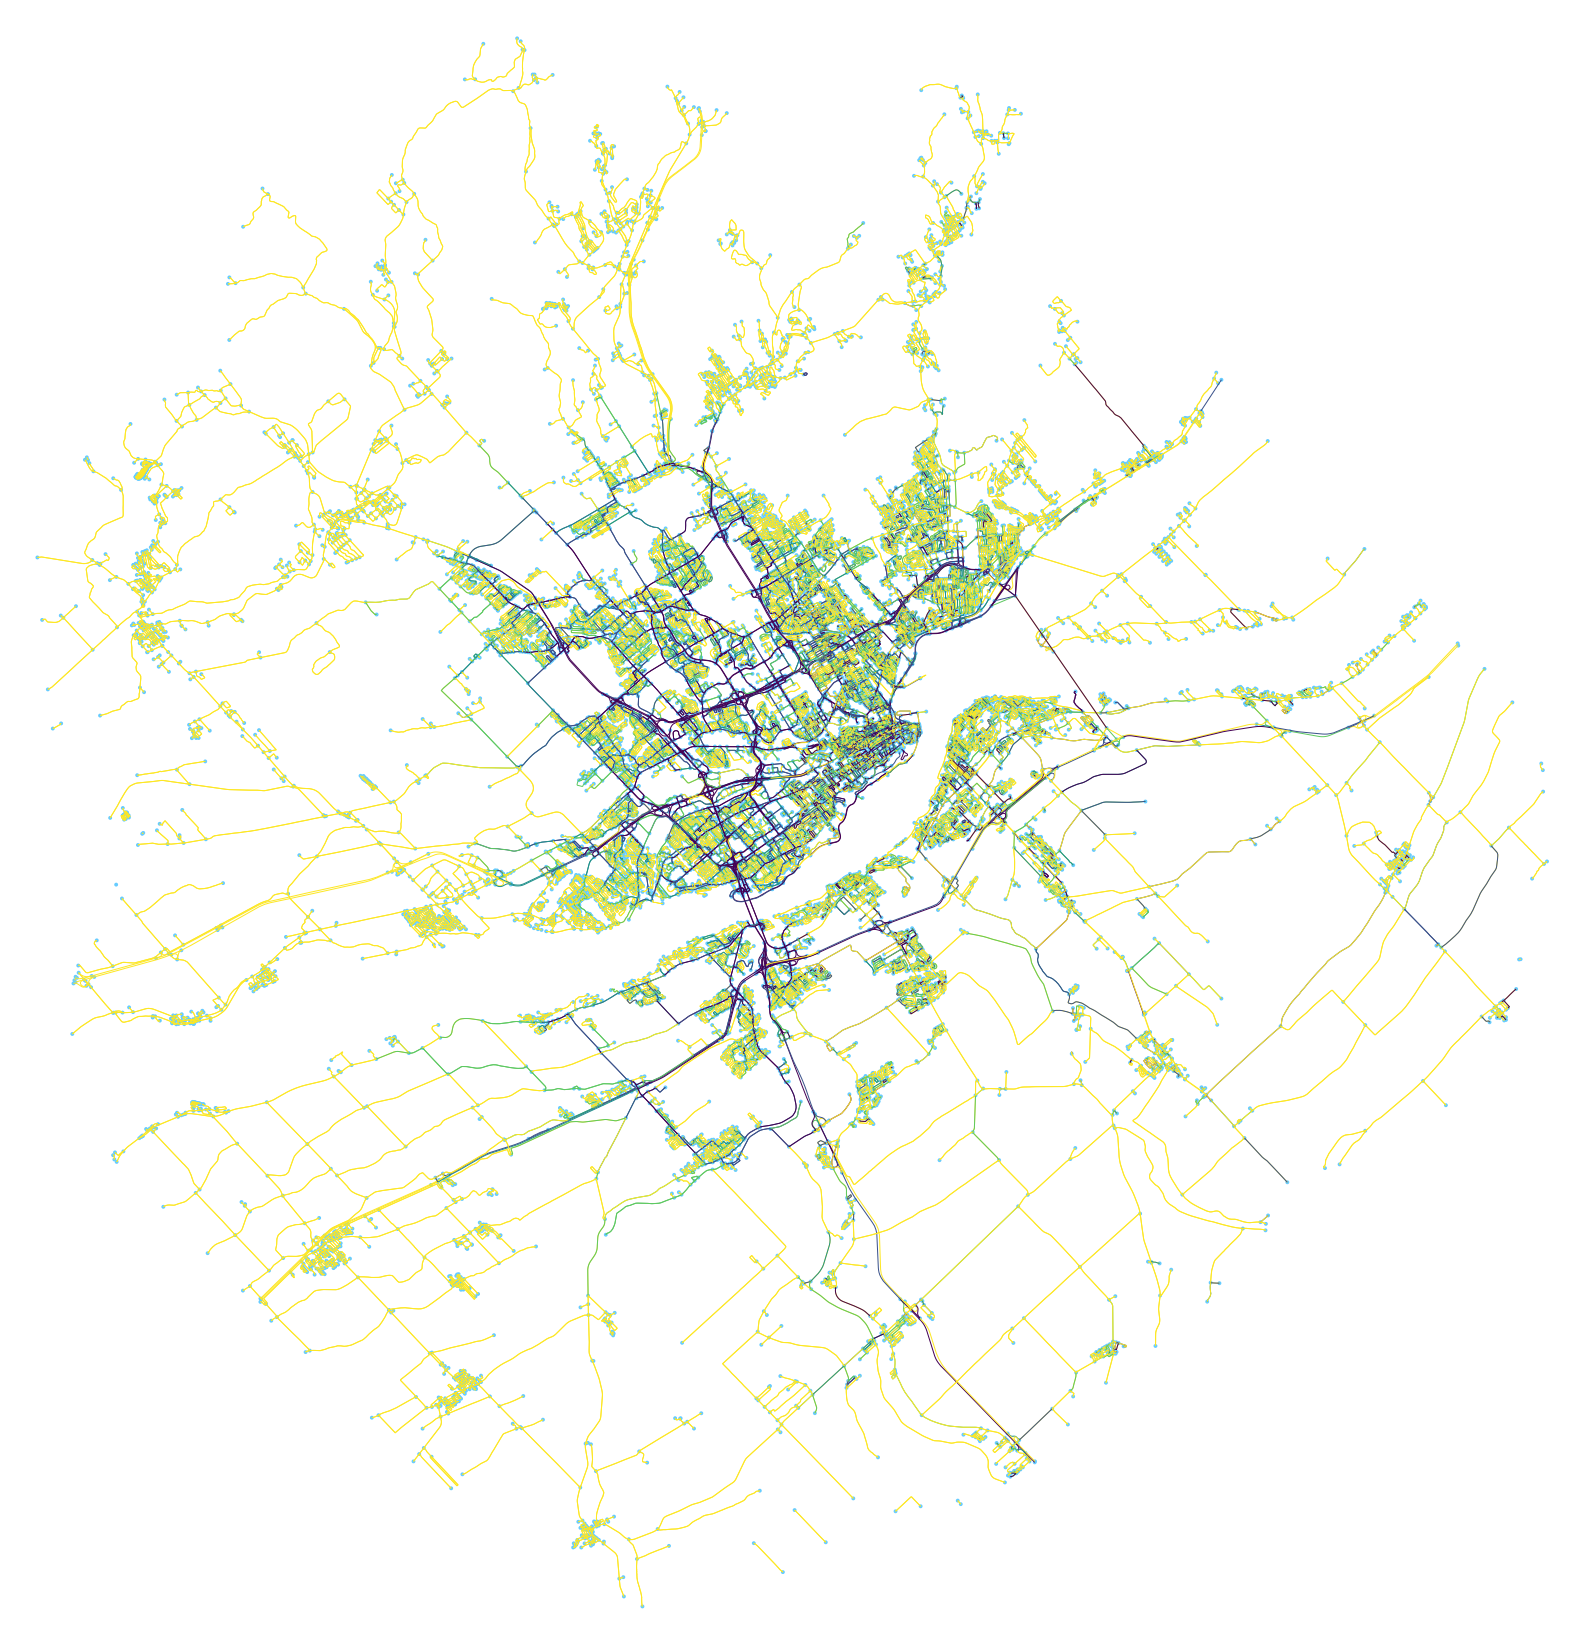

In [341]:
fig, ax = ox.plot_graph(G_bridge, edge_color=ec,  fig_height=30)